In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

In [2]:
class ImageProportionalResizer:
    def resize(self, image, proportion=1/3):
        return cv.resize(image, (int(image.shape[1] * proportion), int(image.shape[0] * proportion)))


In [3]:
resizer = ImageProportionalResizer()
image_01_01 = resizer.resize(cv.imread('fingerprints/finger_print_01_01_C.bmp'))
image_01_02 = resizer.resize(cv.imread('fingerprints/finger_print_01_02_C.bmp'))
image_02 = resizer.resize(cv.imread('fingerprints/finger_print_06.bmp'))
image_03 = cv.imread('fingerprints/example_0.bmp')

In [4]:
print(image_01_01.shape)
print(image_01_02.shape)
print(image_02.shape)
print(image_03.shape)

(180, 126, 3)
(180, 125, 3)
(202, 136, 3)
(103, 96, 3)


In [5]:
class OrientationFieldCreator:
    def __init__(self, block_size):
        self.block_size = block_size

    def _calculate_gradients(self, image, block_size):
        b = block_size // 2
        gradient_x, gradient_y = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3), cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
        g_xx = np.zeros_like(image, dtype=float)
        g_yy = np.zeros_like(image, dtype=float)
        g_xy = np.zeros_like(image, dtype=float)
        for i in range(b, gradient_x.shape[0] - b):
            for j in range(b, gradient_x.shape[1] - b):
                window_x = gradient_x[i-b:i+b+1, j-b:j+b+1]
                window_y = gradient_y[i-b:i+b+1, j-b:j+b+1]
                g_xx[i, j] = np.sum(window_x ** 2)
                g_yy[i, j] = np.sum(window_y ** 2)
                g_xy[i, j] = np.sum(window_x * window_y)
        return g_xx, g_yy, g_xy

    def create_field_for(self, image):
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        g_xx, g_yy, g_xy = self._calculate_gradients(gray_image, self.block_size)
        return np.rad2deg(0.5 * np.pi + 0.5 * np.arctan2(2 * g_xy, g_xx - g_yy)) % 180

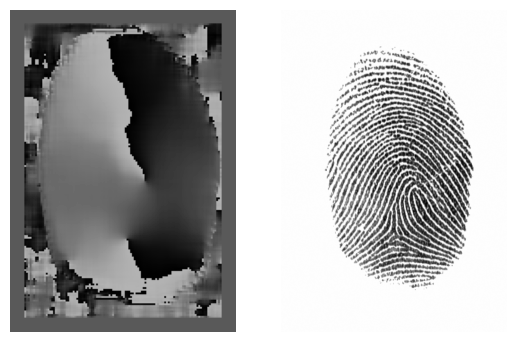

In [77]:
orientation_field_creator = OrientationFieldCreator(16)
if not os.path.exists("orientation_fields"): os.makedirs("orientation_fields")

def show(im1, im2):
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(im1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(im2)

orientation_field_image_01_01 = orientation_field_creator.create_field_for(image_01_01)
cv.imwrite("orientation_fields/orientation_field_image_01_01.png", orientation_field_image_01_01)
show(orientation_field_image_01_01, cv.imread('fingerprints/finger_print_01_01_C.bmp'))

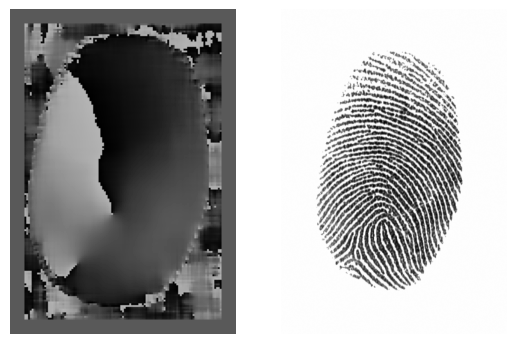

In [48]:
orientation_field_image_01_02 = orientation_field_creator.create_field_for(image_01_02)
cv.imwrite("orientation_fields/orientation_field_image_01_02.png", orientation_field_image_01_02)
show(orientation_field_image_01_02, cv.imread('fingerprints/finger_print_01_02_C.bmp'))

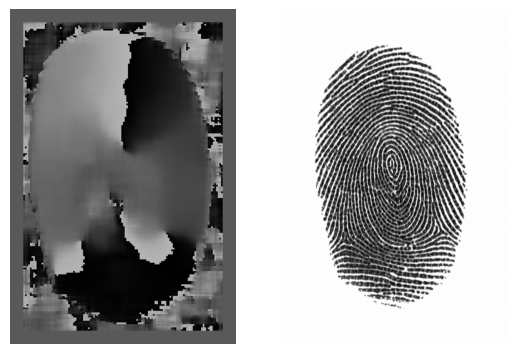

In [49]:
orientation_field_image_02 = orientation_field_creator.create_field_for(image_02)
cv.imwrite("orientation_fields/orientation_field_image_02.png", orientation_field_image_02)
show(orientation_field_image_02, cv.imread('fingerprints/finger_print_06.bmp'))

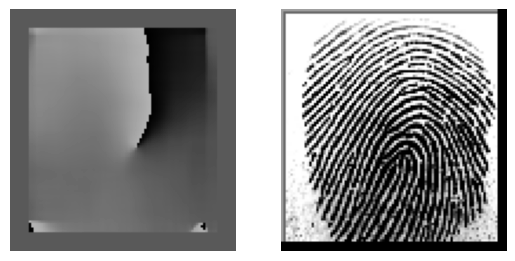

In [50]:
orientation_field_image_03 = orientation_field_creator.create_field_for(image_03)
cv.imwrite("orientation_fields/orientation_field_image_03.png", orientation_field_image_03)
show(orientation_field_image_03, cv.imread('fingerprints/example_0.bmp'))

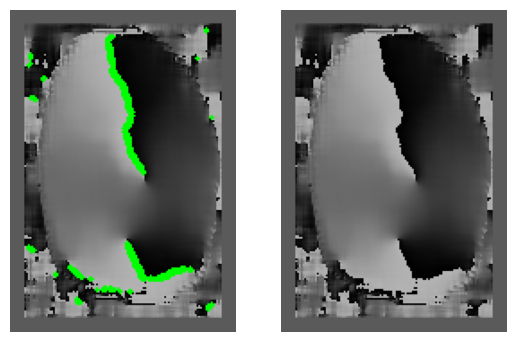

In [141]:
class HighContrastPointDetector:
    def __init__(self, std):
        self.std = std

    def calculate_for(self, image):
        total_gradient_change = self._calculate_gradient(image)
        return np.argwhere(total_gradient_change > self._contrast_threshold(total_gradient_change))

    def _contrast_threshold(self, total_gradient_change):
        return np.mean(total_gradient_change) + self.std * np.std(total_gradient_change)

    def _calculate_gradient(self, image):
        sobel_x_abs = np.abs(cv.Sobel(image, cv.CV_64F, 1, 0, ksize=11))
        sobel_y_abs = np.abs(cv.Sobel(image, cv.CV_64F, 0, 1, ksize=11))
        return sobel_x_abs + sobel_y_abs


def create_image_with_hc(image):
    result = image.copy()
    for point in HighContrastPointDetector(3.7).calculate_for(image):
        cv.circle(result, (point[1], point[0]), 1, (0, 255, 0), -1)
    return result

image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_01_01.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

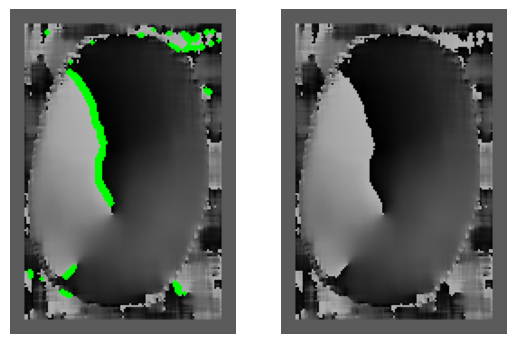

In [142]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_01_02.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

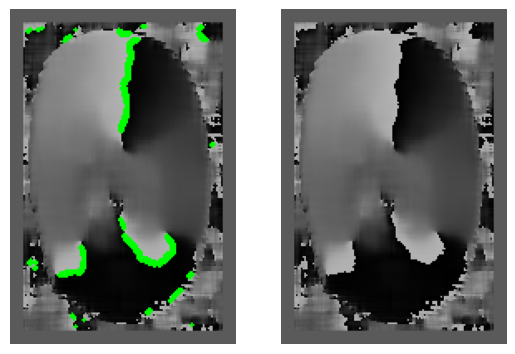

In [143]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_02.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

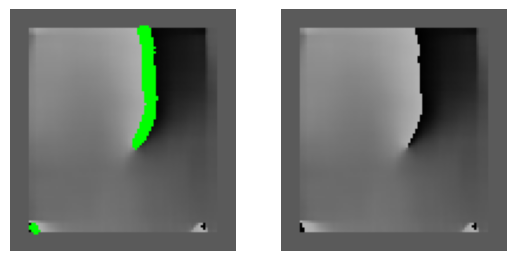

In [144]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_03.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)